In [15]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

# from IPython.core.debugger import set_trace
# set_trace()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import os
import zipfile
import time
from PIL import Image

In [18]:
pathToZip = '/content/drive/MyDrive/DataSets/Cars/RefactoredCars.zip'

z = zipfile.ZipFile(pathToZip, 'r')
z.extractall('/content/sample_data/')

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import os

import FunctionsForNets as myFunc

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [20]:
# Define transforms for dataset

trainTransforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.RandomResizedCrop(224, scale=(0.8, 1.0))], p=0.3)
])

validTransforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

testTransforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

In [21]:
# Loading dataset
rootPath = '/content/sample_data/'
trainPath = os.path.join(rootPath, 'TrainImages')
testPath = os.path.join(rootPath, 'TestImages')
validPath = os.path.join(rootPath, 'ValidImages')

if not (os.path.exists(trainPath) and os.path.exists(testPath) and os.path.exists(validPath)):
  print('Could not find dataset')

trainSet = dset.ImageFolder(trainPath, trainTransforms)
validSet = dset.ImageFolder(validPath, validTransforms)
testSet = dset.ImageFolder(testPath, testTransforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image size -  torch.Size([3, 224, 224])
Num_classes -  196


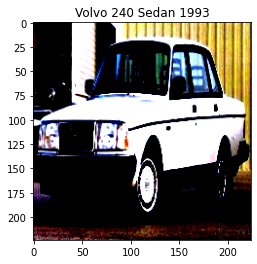

In [22]:
x, y = trainSet[8000]
# print(len(trainSet))

className = list(trainSet.class_to_idx.keys())[list(trainSet.class_to_idx.values()).index(y)] # Get name of class
plt.title(className)
plt.imshow(x.permute(1, 2, 0))
print('image size - ', x.shape)
print('Num_classes - ', len(trainSet.class_to_idx))

In [23]:
trainLoader = DataLoader(trainSet, batch_size=32, sampler=sampler.SubsetRandomSampler(range(0, trainSet.__len__())))
validLoader = DataLoader(validSet, batch_size=32, sampler=sampler.SubsetRandomSampler(range(0, validSet.__len__())))
testLoader = DataLoader(testSet, batch_size=32)

In [24]:
"""
ResNet from this paper Deep Residual Learning for Image Recognition https://arxiv.org/pdf/1512.03385.pdf
"""



class resNetBlock(nn.Module):

    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super().__init__()

        self.expansion = 4
        self.identity_downsample = identity_downsample

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=0)
        self.batchNorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels=out_channels, out_channels= self.expansion*out_channels, kernel_size=1, stride=1, padding=0)
        self.batchNorm3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()

    def forward(self, x):

        identity = x

        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.batchNorm3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)

        return x


class ResNet(nn.Module):

    def __init__(self, block, layers, image_channels, num_classes):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(in_channels=image_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.batchNorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        self.layer1 = self._make_layers(block, layers[0], out_channels=64, stride = 1)
        self.layer2 = self._make_layers(block, layers[1], out_channels=128, stride = 2)
        self.layer3 = self._make_layers(block, layers[2], out_channels=256, stride = 2)
        self.layer4 = self._make_layers(block, layers[3], out_channels=512, stride = 2)

        self.pool2 = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):

        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.pool2(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x



    def _make_layers(self, block, num_residual_blocks, out_channels, stride):

        identity_downsample = None
        layers = []

        if stride != 1 or self.in_channels != 4 * out_channels: # Если шаг ведёт к понижению размерности или итоговые каналы не совпадают с изначальными
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride), # то нужен метод приведения к одной размерности
                                                nn.BatchNorm2d(out_channels * 4)
                                                )
            
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)


def create_ResNet50(img_channels=3, num_classes=1000):
    return ResNet(resNetBlock, [3, 4, 6, 3], img_channels, num_classes)

def create_ResNet152(img_channels=3, num_classes=1000):
    return ResNet(resNetBlock, [3, 8, 36, 3], img_channels, num_classes)


def test(net):
    x = torch.randn(2, 3, 224, 224)
    y = net(x).to('cuda')
    print(y.shape)

In [25]:
def overfit_model(model, optimizer, dataLoader, num_epoch=1, device=torch.device('cpu')):

    import torch.nn.functional as F

    model = model.to(device=device)

    x, y = next(iter(dataLoader))
    x = x.to(device=device, dtype=torch.float32)
    y = y.to(device=device, dtype=torch.long)

    for e in range(num_epoch):

        model.train()
        scores = model(x)
        loss = F.cross_entropy(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        num_samples = 0
        num_correct = 0

        with torch.no_grad():
            
            _, preds = scores.max(1)

            num_samples += preds.shape[0]
            num_correct += (preds == y).sum()

        acc = float(num_correct) / num_samples
        print('Epoch %d, got %.2f percent accuracy'% (e, acc * 100))

In [ ]:
model = create_ResNet152(num_classes=196)
test(model)

optimizer = optim.Adam(model.parameters(), lr=0.001)

torch.Size([2, 196])


In [ ]:
overfit_model(model, optimizer, trainLoader, 25, device)

Epoch 0, got 0.00 percent accuracy
Epoch 1, got 12.50 percent accuracy
Epoch 2, got 25.00 percent accuracy
Epoch 3, got 34.38 percent accuracy
Epoch 4, got 53.12 percent accuracy
Epoch 5, got 50.00 percent accuracy
Epoch 6, got 65.62 percent accuracy
Epoch 7, got 65.62 percent accuracy
Epoch 8, got 50.00 percent accuracy
Epoch 9, got 84.38 percent accuracy
Epoch 10, got 71.88 percent accuracy
Epoch 11, got 90.62 percent accuracy
Epoch 12, got 87.50 percent accuracy
Epoch 13, got 90.62 percent accuracy
Epoch 14, got 100.00 percent accuracy
Epoch 15, got 96.88 percent accuracy
Epoch 16, got 100.00 percent accuracy
Epoch 17, got 100.00 percent accuracy
Epoch 18, got 100.00 percent accuracy
Epoch 19, got 100.00 percent accuracy
Epoch 20, got 100.00 percent accuracy
Epoch 21, got 100.00 percent accuracy
Epoch 22, got 100.00 percent accuracy
Epoch 23, got 100.00 percent accuracy
Epoch 24, got 100.00 percent accuracy


In [ ]:
myFunc.train_model(model, optimizer, trainLoader, validLoader, num_epoch=20, device=device, savePath='/content/drive/MyDrive/CarsModels')

Starting new training
Start 0 epoch
Got 94 / 8144 correct (1.15) in train
Got 43 / 4020 correct (1.07) in validation
Goten new best val accuracy. Save new best model
Start 1 epoch
Got 113 / 8144 correct (1.39) in train
Got 55 / 4020 correct (1.37) in validation
Goten new best val accuracy. Save new best model
Start 2 epoch
Got 113 / 8144 correct (1.39) in train
Got 48 / 4020 correct (1.19) in validation
Start 3 epoch
Got 132 / 8144 correct (1.62) in train
Got 53 / 4020 correct (1.32) in validation
Start 4 epoch


KeyboardInterrupt: ignored

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/CarsModels/best_model.pt')

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 10, device, 
                                 savePath='/content/drive/MyDrive/CarsModels', continueTraining=contTrain)

Continue training from 4 epoch
Start 4 epoch
Got 59 / 3232 correct (1.83) in train
Got 55 / 4020 correct (1.37) in validation
Goten new best val accuracy. Save new best model
Start 5 epoch
Got 68 / 3232 correct (2.10) in train
Got 59 / 4020 correct (1.47) in validation
Goten new best val accuracy. Save new best model
Start 6 epoch
Got 73 / 3232 correct (2.26) in train
Got 82 / 4020 correct (2.04) in validation
Goten new best val accuracy. Save new best model
Start 7 epoch
Got 58 / 3232 correct (1.79) in train
Got 54 / 4020 correct (1.34) in validation
Start 8 epoch
Got 109 / 3232 correct (3.37) in train
Got 120 / 4020 correct (2.99) in validation
Goten new best val accuracy. Save new best model
Start 9 epoch
Got 109 / 3232 correct (3.37) in train
Got 95 / 4020 correct (2.36) in validation


In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/CarsModels/best_model.pt')

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 20, device, 
                                 savePath='/content/drive/MyDrive/CarsModels', continueTraining=contTrain)

Continue training from 10 epoch
Start 10 epoch
Got 125 / 3232 correct (3.87) in train
Got 131 / 4020 correct (3.26) in validation
Goten new best val accuracy. Save new best model
Start 11 epoch
Got 139 / 3232 correct (4.30) in train
Got 138 / 4020 correct (3.43) in validation
Goten new best val accuracy. Save new best model
Start 12 epoch
Got 62 / 3232 correct (1.92) in train
Got 92 / 4020 correct (2.29) in validation
Start 13 epoch
Got 217 / 3232 correct (6.71) in train
Got 178 / 4020 correct (4.43) in validation
Goten new best val accuracy. Save new best model
Start 14 epoch
Got 266 / 3232 correct (8.23) in train
Got 233 / 4020 correct (5.80) in validation
Goten new best val accuracy. Save new best model
Start 15 epoch
Got 276 / 3232 correct (8.54) in train
Got 243 / 4020 correct (6.04) in validation
Goten new best val accuracy. Save new best model
Start 16 epoch
Got 315 / 3232 correct (9.75) in train
Got 254 / 4020 correct (6.32) in validation
Goten new best val accuracy. Save new b

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/CarsModels/best_model.pt')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 25, device, 
                                 savePath='/content/drive/MyDrive/CarsModels', continueTraining=contTrain)

Continue training from 19 epoch
Start 19 epoch
Got 560 / 3232 correct (17.33) in train
Got 407 / 4020 correct (10.12) in validation
Goten new best val accuracy. Save new best model
Start 20 epoch
Got 594 / 3232 correct (18.38) in train
Got 486 / 4020 correct (12.09) in validation
Goten new best val accuracy. Save new best model
Start 21 epoch
Got 715 / 3232 correct (22.12) in train
Got 587 / 4020 correct (14.60) in validation
Goten new best val accuracy. Save new best model
Start 22 epoch
Got 900 / 3232 correct (27.85) in train
Got 588 / 4020 correct (14.63) in validation
Goten new best val accuracy. Save new best model
Start 23 epoch
Got 1262 / 3232 correct (39.05) in train
Got 862 / 4020 correct (21.44) in validation
Goten new best val accuracy. Save new best model
Start 24 epoch
Got 1450 / 3232 correct (44.86) in train
Got 1000 / 4020 correct (24.88) in validation
Goten new best val accuracy. Save new best model


In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/CarsModels/model.pt')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 30, device, 
                                 savePath='/content/drive/MyDrive/CarsModels', continueTraining=contTrain)

Continue training from 25 epoch
Start 25 epoch
Got 1600 / 3232 correct (49.50) in train
Got 1084 / 4020 correct (26.97) in validation
Goten new best val accuracy. Save new best model
Start 26 epoch
Got 1665 / 3232 correct (51.52) in train
Got 1184 / 4020 correct (29.45) in validation
Goten new best val accuracy. Save new best model
Start 27 epoch
Got 1906 / 3232 correct (58.97) in train
Got 1292 / 4020 correct (32.14) in validation
Goten new best val accuracy. Save new best model
Start 28 epoch
Got 2065 / 3232 correct (63.89) in train
Got 1371 / 4020 correct (34.10) in validation
Goten new best val accuracy. Save new best model
Start 29 epoch
Got 2150 / 3232 correct (66.52) in train
Got 1373 / 4020 correct (34.15) in validation
Goten new best val accuracy. Save new best model


In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/CarsModels/model.pt')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 35, device, 
                                 savePath='/content/drive/MyDrive/CarsModels', continueTraining=contTrain)

Continue training from 30 epoch
Start 30 epoch
Got 2488 / 3232 correct (76.98) in train
Got 1541 / 4020 correct (38.33) in validation
Goten new best val accuracy. Save new best model
Start 31 epoch
Got 2411 / 3232 correct (74.60) in train
Got 1514 / 4020 correct (37.66) in validation
Start 32 epoch
Got 2636 / 3232 correct (81.56) in train
Got 1661 / 4020 correct (41.32) in validation
Goten new best val accuracy. Save new best model
Start 33 epoch
Got 2607 / 3232 correct (80.66) in train
Got 1689 / 4020 correct (42.01) in validation
Goten new best val accuracy. Save new best model
Start 34 epoch
Got 2845 / 3232 correct (88.03) in train
Got 1759 / 4020 correct (43.76) in validation
Goten new best val accuracy. Save new best model


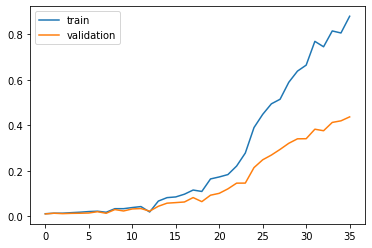

In [ ]:
myFunc.show_accuracy_history(train_acc, val_acc)

In [ ]:
# It should to try smaler model
model = create_ResNet50(num_classes=196)
test(model)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

torch.Size([2, 196])


In [ ]:
overfit_model(model, optimizer, trainLoader, 20, device)

Epoch 0, got 0.00 percent accuracy
Epoch 1, got 9.38 percent accuracy
Epoch 2, got 40.62 percent accuracy
Epoch 3, got 56.25 percent accuracy
Epoch 4, got 78.12 percent accuracy
Epoch 5, got 93.75 percent accuracy
Epoch 6, got 96.88 percent accuracy
Epoch 7, got 96.88 percent accuracy
Epoch 8, got 96.88 percent accuracy
Epoch 9, got 96.88 percent accuracy
Epoch 10, got 96.88 percent accuracy
Epoch 11, got 100.00 percent accuracy
Epoch 12, got 100.00 percent accuracy
Epoch 13, got 100.00 percent accuracy
Epoch 14, got 100.00 percent accuracy
Epoch 15, got 96.88 percent accuracy
Epoch 16, got 100.00 percent accuracy
Epoch 17, got 100.00 percent accuracy
Epoch 18, got 100.00 percent accuracy
Epoch 19, got 100.00 percent accuracy


In [ ]:
myFunc.train_model(model, optimizer, trainLoader, validLoader, num_epoch=20, device=device, savePath='/content/drive/MyDrive/CarsModels')

Starting new training
Start 0 epoch
Got 44 / 3232 correct (1.36) in train
Got 41 / 4020 correct (1.02) in validation
Goten new best val accuracy. Save new best model
Start 1 epoch
Got 37 / 3232 correct (1.14) in train
Got 42 / 4020 correct (1.04) in validation
Goten new best val accuracy. Save new best model
Start 2 epoch
Got 61 / 3232 correct (1.89) in train
Got 58 / 4020 correct (1.44) in validation
Goten new best val accuracy. Save new best model
Start 3 epoch
Got 74 / 3232 correct (2.29) in train
Got 59 / 4020 correct (1.47) in validation
Goten new best val accuracy. Save new best model
Start 4 epoch
Got 84 / 3232 correct (2.60) in train
Got 90 / 4020 correct (2.24) in validation
Goten new best val accuracy. Save new best model
Start 5 epoch
Got 75 / 3232 correct (2.32) in train
Got 76 / 4020 correct (1.89) in validation
Start 6 epoch
Got 92 / 3232 correct (2.85) in train
Got 84 / 4020 correct (2.09) in validation
Start 7 epoch
Got 115 / 3232 correct (3.56) in train
Got 110 / 4020 

([0.013613861386138614,
  0.011448019801980198,
  0.018873762376237623,
  0.022896039603960396,
  0.02599009900990099,
  0.023205445544554455,
  0.028465346534653466,
  0.03558168316831683,
  0.043007425742574254,
  0.03589108910891089,
  0.05631188118811881,
  0.053217821782178217,
  0.05662128712871287,
  0.07518564356435643,
  0.09560643564356436,
  0.12097772277227722,
  0.12159653465346534,
  0.15841584158415842,
  0.1905940594059406,
  0.23267326732673269],
 [0.010199004975124378,
  0.010447761194029851,
  0.014427860696517412,
  0.014676616915422885,
  0.022388059701492536,
  0.01890547263681592,
  0.020895522388059702,
  0.02736318407960199,
  0.03507462686567164,
  0.022139303482587063,
  0.039303482587064675,
  0.03557213930348259,
  0.04378109452736319,
  0.04875621890547264,
  0.052487562189054725,
  0.08009950248756219,
  0.0781094527363184,
  0.10920398009950248,
  0.11940298507462686,
  0.1338308457711443])

In [ ]:
train_acc, val_acc = _

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/CarsModels/model.pt')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 30, device, 
                                 savePath='/content/drive/MyDrive/CarsModels', continueTraining=contTrain)

Continue training from 20 epoch
Start 20 epoch
Got 926 / 3232 correct (28.65) in train
Got 650 / 4020 correct (16.17) in validation
Goten new best val accuracy. Save new best model
Start 21 epoch
Got 1106 / 3232 correct (34.22) in train
Got 762 / 4020 correct (18.96) in validation
Goten new best val accuracy. Save new best model
Start 22 epoch
Got 1104 / 3232 correct (34.16) in train
Got 797 / 4020 correct (19.83) in validation
Goten new best val accuracy. Save new best model
Start 23 epoch
Got 1181 / 3232 correct (36.54) in train
Got 842 / 4020 correct (20.95) in validation
Goten new best val accuracy. Save new best model
Start 24 epoch
Got 1323 / 3232 correct (40.93) in train
Got 858 / 4020 correct (21.34) in validation
Goten new best val accuracy. Save new best model
Start 25 epoch
Got 1746 / 3232 correct (54.02) in train
Got 1165 / 4020 correct (28.98) in validation
Goten new best val accuracy. Save new best model
Start 26 epoch
Got 1762 / 3232 correct (54.52) in train
Got 1138 / 4

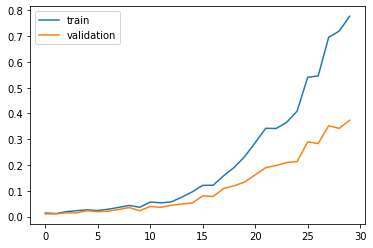

In [ ]:
myFunc.show_accuracy_history(train_acc, val_acc)

In [26]:
# Might be worth making data augmentation more complex

trainTransforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(brightness=0.3)], p=0.5),
    T.RandomGrayscale(p=0.3),
    T.RandomApply([T.RandomRotation(degrees=(-25, 25))], p=0.5),
    T.RandomApply([T.RandomResizedCrop(224, scale=(0.6, 0.8))], p=1.0)
])
trainSet = dset.ImageFolder(trainPath, trainTransforms)
trainLoader = DataLoader(trainSet, batch_size=32, sampler=sampler.SubsetRandomSampler(range(0, trainSet.__len__())))

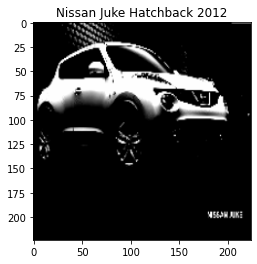

In [ ]:
x, y = trainSet[7000]

className = list(trainSet.class_to_idx.keys())[list(trainSet.class_to_idx.values()).index(y)]
plt.title(className)
plt.imshow(x.permute(1, 2, 0))

In [13]:
model = create_ResNet50(num_classes=196)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [ ]:
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, num_epoch=10, device=device, savePath='/content/drive/MyDrive/CarsModels')

Starting new training
Start 0 epoch
Got 22 / 3232 correct (0.68) in train
Got 24 / 4020 correct (0.60) in validation
Goten new best val accuracy. Save new best model
Start 1 epoch
Got 27 / 3232 correct (0.84) in train
Got 33 / 4020 correct (0.82) in validation
Goten new best val accuracy. Save new best model
Start 2 epoch
Got 27 / 3232 correct (0.84) in train
Got 34 / 4020 correct (0.85) in validation
Goten new best val accuracy. Save new best model
Start 3 epoch
Got 37 / 3232 correct (1.14) in train
Got 54 / 4020 correct (1.34) in validation
Goten new best val accuracy. Save new best model
Start 4 epoch
Got 54 / 3232 correct (1.67) in train
Got 62 / 4020 correct (1.54) in validation
Goten new best val accuracy. Save new best model
Start 5 epoch
Got 55 / 3232 correct (1.70) in train
Got 62 / 4020 correct (1.54) in validation
Start 6 epoch
Got 13 / 3232 correct (0.40) in train
Got 28 / 4020 correct (0.70) in validation
Start 7 epoch
Got 59 / 3232 correct (1.83) in train
Got 64 / 4020 co

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/CarsModels/model.pt')
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 25, device, 
                                 savePath='/content/drive/MyDrive/CarsModels', continueTraining=contTrain)

Continue training from 10 epoch
Start 10 epoch
Got 77 / 3232 correct (2.38) in train
Got 105 / 4020 correct (2.61) in validation
Goten new best val accuracy. Save new best model
Start 11 epoch
Got 84 / 3232 correct (2.60) in train
Got 79 / 4020 correct (1.97) in validation
Start 12 epoch
Got 75 / 3232 correct (2.32) in train
Got 76 / 4020 correct (1.89) in validation
Start 13 epoch
Got 97 / 3232 correct (3.00) in train
Got 87 / 4020 correct (2.16) in validation
Start 14 epoch
Got 115 / 3232 correct (3.56) in train
Got 137 / 4020 correct (3.41) in validation
Goten new best val accuracy. Save new best model
Start 15 epoch
Got 101 / 3232 correct (3.12) in train
Got 120 / 4020 correct (2.99) in validation
Start 16 epoch
Got 170 / 3232 correct (5.26) in train
Got 208 / 4020 correct (5.17) in validation
Goten new best val accuracy. Save new best model
Start 17 epoch
Got 191 / 3232 correct (5.91) in train
Got 163 / 4020 correct (4.05) in validation
Start 18 epoch
Got 164 / 3232 correct (5.07)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/CarsModels/model.pt')
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 30, device, 
                                 savePath='/content/drive/MyDrive/CarsModels', continueTraining=contTrain)

Continue training from 25 epoch
Start 25 epoch
Got 268 / 3232 correct (8.29) in train
Got 383 / 4020 correct (9.53) in validation
Start 26 epoch
Got 226 / 3232 correct (6.99) in train
Got 300 / 4020 correct (7.46) in validation
Start 27 epoch


KeyboardInterrupt: ignored

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/CarsModels/best_model.pt')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 30, device, 
                                 savePath='/content/drive/MyDrive/CarsModels', continueTraining=contTrain)

Continue training from 25 epoch
Start 25 epoch
Got 228 / 3232 correct (7.05) in train
Got 257 / 4020 correct (6.39) in validation
Start 26 epoch
Got 315 / 3232 correct (9.75) in train
Got 485 / 4020 correct (12.06) in validation
Goten new best val accuracy. Save new best model
Start 27 epoch
Got 307 / 3232 correct (9.50) in train
Got 381 / 4020 correct (9.48) in validation
Start 28 epoch
Got 379 / 3232 correct (11.73) in train
Got 472 / 4020 correct (11.74) in validation
Start 29 epoch
Got 410 / 3232 correct (12.69) in train
Got 499 / 4020 correct (12.41) in validation
Goten new best val accuracy. Save new best model


In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/CarsModels/best_model.pt')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 40, device, 
                                 savePath='/content/drive/MyDrive/CarsModels', continueTraining=contTrain)

Continue training from 30 epoch
Start 30 epoch
Got 333 / 3232 correct (10.30) in train
Got 352 / 4020 correct (8.76) in validation
Start 31 epoch
Got 552 / 3232 correct (17.08) in train
Got 551 / 4020 correct (13.71) in validation
Goten new best val accuracy. Save new best model
Start 32 epoch
Got 523 / 3232 correct (16.18) in train
Got 526 / 4020 correct (13.08) in validation
Start 33 epoch
Got 582 / 3232 correct (18.01) in train
Got 594 / 4020 correct (14.78) in validation
Goten new best val accuracy. Save new best model
Start 34 epoch
Got 592 / 3232 correct (18.32) in train
Got 547 / 4020 correct (13.61) in validation
Start 35 epoch
Got 624 / 3232 correct (19.31) in train
Got 799 / 4020 correct (19.88) in validation
Goten new best val accuracy. Save new best model
Start 36 epoch
Got 672 / 3232 correct (20.79) in train
Got 575 / 4020 correct (14.30) in validation
Start 37 epoch
Got 687 / 3232 correct (21.26) in train
Got 556 / 4020 correct (13.83) in validation
Start 38 epoch
Got 804

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/CarsModels/model.pt')

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 50, device, 
                                 savePath='/content/drive/MyDrive/CarsModels', continueTraining=contTrain)

Continue training from 40 epoch
Start 40 epoch
Got 942 / 3232 correct (29.15) in train
Got 858 / 4020 correct (21.34) in validation
Start 41 epoch
Got 951 / 3232 correct (29.42) in train
Got 1007 / 4020 correct (25.05) in validation
Start 42 epoch
Got 952 / 3232 correct (29.46) in train
Got 996 / 4020 correct (24.78) in validation
Start 43 epoch
Got 1132 / 3232 correct (35.02) in train
Got 1094 / 4020 correct (27.21) in validation
Goten new best val accuracy. Save new best model
Start 44 epoch
Got 1080 / 3232 correct (33.42) in train
Got 1041 / 4020 correct (25.90) in validation
Start 45 epoch
Got 1114 / 3232 correct (34.47) in train
Got 909 / 4020 correct (22.61) in validation
Start 46 epoch
Got 1201 / 3232 correct (37.16) in train
Got 1344 / 4020 correct (33.43) in validation
Goten new best val accuracy. Save new best model
Start 47 epoch
Got 1161 / 3232 correct (35.92) in train
Got 1343 / 4020 correct (33.41) in validation
Start 48 epoch
Got 1372 / 3232 correct (42.45) in train
Got 

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/CarsModels/model.pt')

model = create_ResNet50(num_classes=196)
model = model.to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 60, device, 
                                 savePath='/content/drive/MyDrive/CarsModels', continueTraining=contTrain)

Continue training from 50 epoch
Start 50 epoch
Got 1435 / 3232 correct (44.40) in train
Got 1226 / 4020 correct (30.50) in validation
Goten new best val accuracy. Save new best model
Start 51 epoch
Got 1273 / 3232 correct (39.39) in train
Got 1169 / 4020 correct (29.08) in validation
Start 52 epoch
Got 1473 / 3232 correct (45.58) in train
Got 1398 / 4020 correct (34.78) in validation
Goten new best val accuracy. Save new best model
Start 53 epoch
Got 1410 / 3232 correct (43.63) in train
Got 1356 / 4020 correct (33.73) in validation
Start 54 epoch
Got 1603 / 3232 correct (49.60) in train
Got 1494 / 4020 correct (37.16) in validation
Goten new best val accuracy. Save new best model
Start 55 epoch
Got 1666 / 3232 correct (51.55) in train
Got 1535 / 4020 correct (38.18) in validation
Goten new best val accuracy. Save new best model
Start 56 epoch
Got 1667 / 3232 correct (51.58) in train
Got 1678 / 4020 correct (41.74) in validation
Goten new best val accuracy. Save new best model
Start 57 

In [14]:
checkpoint = torch.load('/content/drive/MyDrive/CarsModels/model.pt')

model = create_ResNet50(num_classes=196)
model = model.to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 70, device, 
                                 savePath='/content/drive/MyDrive/CarsModels', continueTraining=contTrain)

Continue training from 60 epoch
Start 60 epoch
Got 1724 / 3232 correct (53.34) in train
Got 1688 / 4020 correct (41.99) in validation
Goten new best val accuracy. Save new best model
Start 61 epoch
Got 1795 / 3232 correct (55.54) in train
Got 1692 / 4020 correct (42.09) in validation
Goten new best val accuracy. Save new best model
Start 62 epoch
Got 1745 / 3232 correct (53.99) in train
Got 1569 / 4020 correct (39.03) in validation
Start 63 epoch
Got 1851 / 3232 correct (57.27) in train
Got 1643 / 4020 correct (40.87) in validation
Start 64 epoch
Got 1794 / 3232 correct (55.51) in train
Got 1549 / 4020 correct (38.53) in validation
Start 65 epoch
Got 1839 / 3232 correct (56.90) in train
Got 1767 / 4020 correct (43.96) in validation
Goten new best val accuracy. Save new best model
Start 66 epoch
Got 1925 / 3232 correct (59.56) in train
Got 1829 / 4020 correct (45.50) in validation
Goten new best val accuracy. Save new best model
Start 67 epoch
Got 1717 / 3232 correct (53.12) in train
Go

In [27]:
checkpoint = torch.load('/content/drive/MyDrive/CarsModels/model.pt')

model = create_ResNet50(num_classes=196)
model = model.to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 90, device, 
                                 savePath='/content/drive/MyDrive/CarsModels', continueTraining=contTrain)

Continue training from 70 epoch
Start 70 epoch
Got 2130 / 3232 correct (65.90) in train
Got 2027 / 4020 correct (50.42) in validation
Goten new best val accuracy. Save new best model
Start 71 epoch
Got 2149 / 3232 correct (66.49) in train
Got 1906 / 4020 correct (47.41) in validation
Start 72 epoch
Got 2086 / 3232 correct (64.54) in train
Got 1830 / 4020 correct (45.52) in validation
Start 73 epoch
Got 2100 / 3232 correct (64.98) in train
Got 1833 / 4020 correct (45.60) in validation
Start 74 epoch


KeyboardInterrupt: ignored

In [29]:
checkpoint = torch.load('/content/drive/MyDrive/CarsModels/best_model.pt')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)

model.load_state_dict(checkpoint['Model_state_dict'])
optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 90, device, 
                                 savePath='/content/drive/MyDrive/CarsModels', continueTraining=contTrain)

Continue training from 71 epoch
Start 71 epoch
Got 2012 / 3232 correct (62.25) in train
Got 1868 / 4020 correct (46.47) in validation
Start 72 epoch
Got 2128 / 3232 correct (65.84) in train
Got 1936 / 4020 correct (48.16) in validation
Start 73 epoch
Got 2023 / 3232 correct (62.59) in train
Got 1922 / 4020 correct (47.81) in validation
Start 74 epoch
Got 2099 / 3232 correct (64.94) in train
Got 1879 / 4020 correct (46.74) in validation
Start 75 epoch
Got 2006 / 3232 correct (62.07) in train
Got 1794 / 4020 correct (44.63) in validation
Start 76 epoch
Got 2166 / 3232 correct (67.02) in train
Got 1990 / 4020 correct (49.50) in validation
Start 77 epoch
Got 2147 / 3232 correct (66.43) in train
Got 1925 / 4020 correct (47.89) in validation
Start 78 epoch
Got 2207 / 3232 correct (68.29) in train
Got 2038 / 4020 correct (50.70) in validation
Goten new best val accuracy. Save new best model
Start 79 epoch
Got 2079 / 3232 correct (64.33) in train
Got 1749 / 4020 correct (43.51) in validation
S

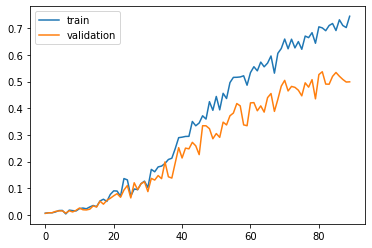

In [30]:
myFunc.show_accuracy_history(train_acc, val_acc)

# it seems like overfitting